[spline] inverse ready; intensity domain: [1998.01, 4467.01]
[self-test] max |log10c − inverse(forward)| = 4.168e-01
Saved 53 fits (bg = min bin in chamber) to 3F_RHL_concentration.csv
Saved 1543 profile rows to 3F_RHL_concentration_profiles.csv
Saved 1543 bg-corrected intensity rows to 3F_RHL_bg_corrected_intensities.csv
Saved per-chamber backgrounds (min bin) to 3F_RHL_bg_minbin_by_chamber.csv


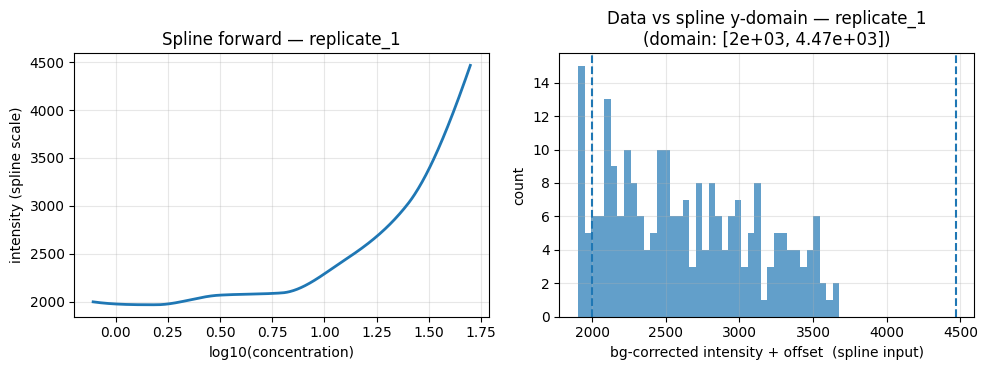

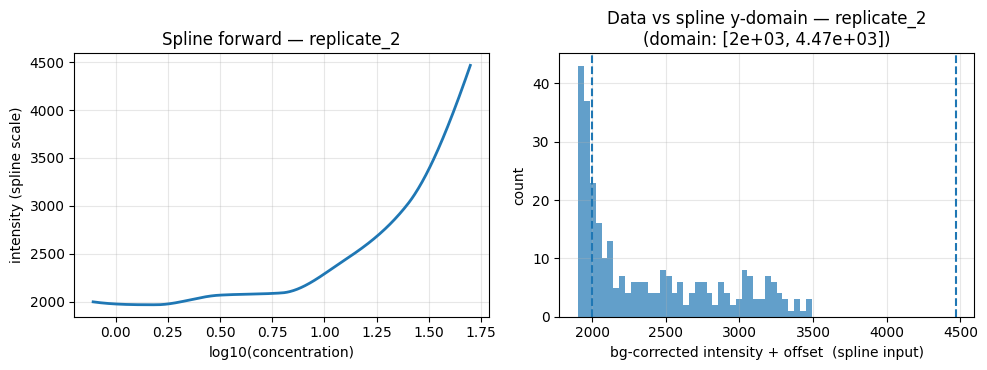

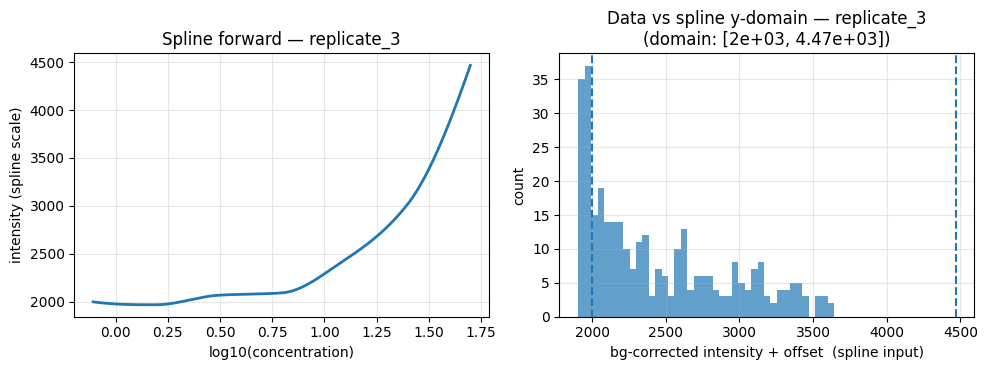

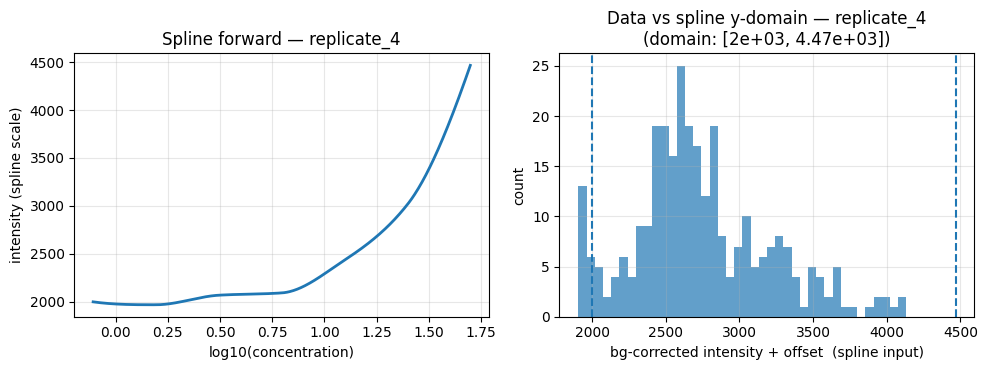

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator
import json
import re
import warnings

# =========================
# Config
# =========================
RHL_CSV    = r'C:\Users\raachben\Documents\PhD\projets\Guilia\Paper\Analysis\Figures\Figures3\3D_rhl_mcherry\3D_RHL_Mcherry_gradient_visualization.csv'
JSON       = r'C:\Users\raachben\Documents\PhD\projets\Guilia\Paper\Analysis\Figures\Figures3\3E_rhl_calibration\3E_pooled_calibration.json'

OUTPUT_CSV         = r'3F_RHL_concentration.csv'
OUTPUT_PROFILE_CSV = r'3F_RHL_concentration_profiles.csv'
OUTPUT_BGCORR_CSV  = r'3F_RHL_bg_corrected_intensities.csv' # tidy per-bin, bg-corrected intensities
OUTPUT_BG_CHAMBER  = r'3F_RHL_bg_minbin_by_chamber.csv'     # per-chamber bg log (NEW)

# Fitting/display options
intensity_col = 'median_intensity'
cut_off = 1
plot_each = False
bin_size = 50/30
figsize = (5, 4)
L_margin_bins = 1.0

# ===== Choose calibration mode =====
CALIBRATION_MODE = 'hybrid'   # 'hill' | 'spline' | 'hybrid'
SPLINE_CLAMP = True
RUN_DEBUG_PLOTS = True
DEBUG_MAX_REPS  = 4

# =========================
# Load calibration
# =========================
with open(JSON, "r") as f:
    cal = json.load(f)

calibration_a  = cal.get("params", {}).get("a", None)
calibration_c  = cal.get("params", {}).get("c", None)
calibration_b  = cal.get("params", {}).get("b", None)
cal_y0 = float(cal.get("y0", 0.0))

spline_xlog10 = cal.get("spline_xlog10", None)
spline_y      = cal.get("spline_y", None)
spline_cutoff = cal.get("spline_cutoff", None)
CAL_SPLINE_RESPONSE_OFFSET = float(cal.get("spline_response_offset", cal_y0))

pchip_forward = None
pchip_inverse = None
_xlog_arr_for_selftest = None

if spline_xlog10 is not None and spline_y is not None:
    xlog_arr = np.asarray(spline_xlog10, dtype=float)
    y_arr    = np.asarray(spline_y, dtype=float)
    order = np.argsort(xlog_arr)
    xlog_arr = xlog_arr[order]
    y_arr    = y_arr[order]

    pchip_forward = PchipInterpolator(xlog_arr, y_arr, extrapolate=False)

    y_mono = np.maximum.accumulate(y_arr)
    y_unique, idx = np.unique(y_mono, return_index=True)
    xlog_unique = xlog_arr[idx]
    if len(y_unique) >= 2:
        pchip_inverse = PchipInterpolator(y_unique, xlog_unique, extrapolate=False)
        print(f"[spline] inverse ready; intensity domain: [{pchip_inverse.x[0]:.6g}, {pchip_inverse.x[-1]:.6g}]")
    else:
        print("[spline] not enough unique points to build inverse; spline disabled.")
    _xlog_arr_for_selftest = xlog_arr.copy()

_effective_mode = CALIBRATION_MODE
if CALIBRATION_MODE in ('spline', 'hybrid') and pchip_inverse is None:
    warnings.warn("[calibration] Spline inverse not available; falling back to 'hill'.")
    _effective_mode = 'hill'

if (pchip_forward is not None) and (pchip_inverse is not None):
    grid = np.linspace(_xlog_arr_for_selftest.min(), _xlog_arr_for_selftest.max(), 250)
    y_sim = pchip_forward(grid)
    logc_back = pchip_inverse(y_sim)
    err = np.nanmax(np.abs(grid - logc_back))
    print(f"[self-test] max |log10c − inverse(forward)| = {err:.3e}")

# =========================
# Helpers
# =========================
def std_sinh(z):
    z = np.asarray(z)
    return np.where(np.abs(z) < 1e-8, z, np.sinh(z))

def uptake_diffusion_sinh(x, c_max, L, A):
    sA = np.sqrt(A)
    return c_max * np.sinh(sA * (L - x)) / std_sinh(sA * L)

def hill_function_inverse(y, a, c, b):
    return c * (y / (a - y))**(1/b)

def intensity_to_concentration(intensity_vec: np.ndarray) -> np.ndarray:
    y_bg = np.asarray(intensity_vec, dtype=float)
    out = np.full_like(y_bg, np.nan, dtype=float)

    if _effective_mode == 'hill':
        if None in (calibration_a, calibration_c, calibration_b):
            return out
        y_eff = y_bg - cal_y0
        valid = np.isfinite(y_eff) & (y_eff >= 0) & (y_eff < calibration_a)
        out[valid] = hill_function_inverse(y_eff[valid], calibration_a, calibration_c, calibration_b)
        return out

    if pchip_inverse is None:
        return out

    y_for_spline = y_bg + CAL_SPLINE_RESPONSE_OFFSET
    y_dom_lo, y_dom_hi = float(pchip_inverse.x[0]), float(pchip_inverse.x[-1])
    mask_finite = np.isfinite(y_for_spline)

    yq = y_for_spline.copy()
    if SPLINE_CLAMP:
        yq[mask_finite & (yq < y_dom_lo)] = y_dom_lo
        yq[mask_finite & (yq > y_dom_hi)] = y_dom_hi

    if _effective_mode == 'hybrid' and (spline_cutoff is not None):
        logc_try = np.full_like(yq, np.nan, dtype=float)
        with np.errstate(all='ignore'):
            logc_try[mask_finite] = pchip_inverse(yq[mask_finite])
        c_try = np.power(10.0, logc_try)
        can_use_spline = mask_finite & np.isfinite(c_try) & (c_try <= float(spline_cutoff))
        out[can_use_spline] = c_try[can_use_spline]

        rem_mask = mask_finite & ~can_use_spline
        if rem_mask.any() and None not in (calibration_a, calibration_c, calibration_b):
            y_eff = y_bg[rem_mask] - cal_y0
            valid_hill = np.isfinite(y_eff) & (y_eff >= 0) & (y_eff < calibration_a)
            tmp = np.full_like(y_eff, np.nan, dtype=float)
            tmp[valid_hill] = hill_function_inverse(y_eff[valid_hill], calibration_a, calibration_c, calibration_b)
            out[rem_mask] = tmp
        return out

    with np.errstate(all='ignore'):
        logc = pchip_inverse(yq)
    out[mask_finite] = np.power(10.0, logc[mask_finite])
    return out

def propagate_tail_nans_after_second(x, arrays):
    x = np.asarray(x)
    order = np.argsort(x)
    nan_count = 0
    cut_x = None
    for k in order:
        if any(not np.isfinite(a[k]) for a in arrays):
            nan_count += 1
            if nan_count >= 2:
                cut_x = x[k]; break
    if cut_x is None:
        return arrays
    tail_mask = x > cut_x
    out = []
    for a in arrays:
        a2 = a.copy()
        a2[tail_mask] = np.nan
        out.append(a2)
    return out

def _normalize_replicate_key(rep_val) -> str:
    if pd.isna(rep_val):
        raise ValueError("Replicate is NaN/None.")
    s = str(rep_val).strip().lower()
    m = re.search(r'(\d+)', s)
    return f"replicate_{int(m.group(1))}" if m else s

# =========================
# Load main binned data and fit (per-chamber min-bin background)
# =========================
outer = pd.read_csv(RHL_CSV)

needed_cols = {'replicate', 'pos', 'y_bin', intensity_col}
missing = needed_cols - set(outer.columns)
if missing:
    raise RuntimeError(f"Binned RHL_CSV missing required columns: {sorted(missing)}")

combos = outer[['replicate', 'pos']].drop_duplicates().reset_index(drop=True)

results = []
profile_rows = []
bgcorr_rows = []
bg_log_rows = []

for _, row in combos.iterrows():
    rep_raw, pos = row['replicate'], row['pos']
    rep_key = _normalize_replicate_key(rep_raw)

    df_o = outer[(outer['replicate'] == rep_raw) & (outer['pos'] == pos)].copy()
    xdata_bins = df_o['y_bin'].to_numpy(dtype=float)
    ydata_raw  = df_o[intensity_col].to_numpy(dtype=float)

    # --- NEW: chamber-specific background = minimum finite bin intensity in this chamber ---
    valid_raw = np.isfinite(ydata_raw)
    if not np.any(valid_raw):
        BG_VALUE = np.nan
    else:
        BG_VALUE = float(np.nanmin(ydata_raw[valid_raw]))

    # subtract; guard tiny negatives due to FP
    y_bg_corrected = ydata_raw - BG_VALUE
    y_bg_corrected = np.where(np.isfinite(y_bg_corrected), np.maximum(y_bg_corrected, 0.0), np.nan)

    # === Map intensity -> concentration ===
    ydata = intensity_to_concentration(y_bg_corrected)

    # After second NaN, NaN-out the tail
    y_bg_corrected, ydata = propagate_tail_nans_after_second(xdata_bins, [y_bg_corrected, ydata])

    # Collect bg-corrected intensities (tidy)
    if bin_size is not None:
        x_phys = xdata_bins * float(bin_size)
    else:
        x_phys = np.full_like(xdata_bins, np.nan, dtype=float)
    for yb, xp, bg_corr_v in zip(xdata_bins, x_phys, y_bg_corrected):
        bgcorr_rows.append({
            'replicate': rep_raw,
            'pos': pos,
            'y_bin': float(yb),
            'x_physical': float(xp) if np.isfinite(xp) else np.nan,
            'intensity_bg_corrected': (float(bg_corr_v) if np.isfinite(bg_corr_v) else np.nan),
            'bg_offset': (float(BG_VALUE) if np.isfinite(BG_VALUE) else np.nan),
            'bg_method': 'min_bin_in_chamber'
        })

    # Log per-chamber background
    bg_log_rows.append({
        'replicate': rep_raw,
        'pos': pos,
        'bg_offset_min_bin': (float(BG_VALUE) if np.isfinite(BG_VALUE) else np.nan),
        'n_bins': int(valid_raw.sum()),
        'bg_method': 'min_bin_in_chamber'
    })

    # Trim for fitting
    if isinstance(cut_off, (int, np.integer)) and cut_off >= 0:
        xfit_bins = xdata_bins[cut_off:]
        yfit_all  = ydata[cut_off:]
    else:
        raise ValueError("cut_off must be a non-negative integer")

    # Fit uptake–diffusion curve to concentration profile
    if xfit_bins.size == 0:
        c_max_fit = A_fit = L_fit = np.nan
        r2 = rmse = np.nan
        status = 'no_data'
        fit_at_bins = np.full_like(xdata_bins, np.nan, dtype=float)
    else:
        last_bin_available = float(np.max(xfit_bins))
        L_lower = last_bin_available + max(1.0, float(L_margin_bins))

        mask_fit = np.isfinite(yfit_all)
        x_fit = xfit_bins[mask_fit]
        y_fit = yfit_all[mask_fit]

        if y_fit.size < 3:
            c_max_fit = A_fit = L_fit = np.nan
            r2 = rmse = np.nan
            status = 'too_few_points'
            fit_at_bins = np.full_like(xdata_bins, np.nan, dtype=float)
        else:
            def model_free_L(x, c_max, L, A):
                return uptake_diffusion_sinh(x, c_max, L, A)

            yfit_max = float(np.max(y_fit))
            p0 = [max(1e-9, 3.0 * yfit_max),  # c_max
                  L_lower + 1.0,              # L
                  1.0]                        # A

            eps = 1e-12
            lower_bounds = [0.0, L_lower, eps]
            upper_bounds = [np.inf, 2*L_lower, np.inf]

            try:
                popt, _ = curve_fit(model_free_L, x_fit, y_fit,
                                    p0=p0, bounds=(lower_bounds, upper_bounds), maxfev=10000)
                c_max_fit, L_fit, A_fit = map(float, popt)
                status = f"success({_effective_mode})"

                y_pred = model_free_L(x_fit, *popt)
                resid = y_fit - y_pred
                ssr = float(np.sum(resid**2))
                tss = float(np.sum((y_fit - np.mean(y_fit))**2))
                r2 = 1 - ssr / tss if tss > 0 else np.nan
                rmse = float(np.sqrt(ssr / y_fit.size)) if y_fit.size > 0 else np.nan

                fit_at_bins = model_free_L(xdata_bins, c_max_fit, L_fit, A_fit)

            except Exception as e:
                c_max_fit = A_fit = L_fit = np.nan
                r2 = rmse = np.nan
                status = f'fit_error: {e}'
                fit_at_bins = np.full_like(xdata_bins, np.nan, dtype=float)

    # Per-fit summary
    results.append({
        'replicate': rep_raw,
        'pos': pos,
        'bg_offset': (float(BG_VALUE) if np.isfinite(BG_VALUE) else np.nan),
        'bg_method': 'min_bin_in_chamber',
        'c_max': c_max_fit,
        'L': L_fit,
        'A': A_fit,
        'r2': r2,
        'rmse': rmse,
        'status': status
    })

    # Per-bin profile rows
    for yb, xp, raw_v, bg_corr_v, conc, fy in zip(
        xdata_bins, x_phys, ydata_raw, y_bg_corrected, ydata, fit_at_bins
    ):
        profile_rows.append({
            'replicate': rep_raw,
            'pos': pos,
            'y_bin': float(yb),
            'x_physical': float(xp) if np.isfinite(xp) else np.nan,
            'intensity_raw': (float(raw_v) if np.isfinite(raw_v) else np.nan),
            'intensity_bg_corrected': (float(bg_corr_v) if np.isfinite(bg_corr_v) else np.nan),
            'bg_offset': (float(BG_VALUE) if np.isfinite(BG_VALUE) else np.nan),
            'bg_method': 'min_bin_in_chamber',
            'estimated_rhl_concentration': (float(conc) if np.isfinite(conc) else np.nan),
            'fit_y': (float(fy) if np.isfinite(fy) else np.nan),
            'status': status
        })

    # Optional per-chamber plots
    if plot_each and xdata_bins.size:
        if bin_size is not None:
            x_plot = xdata_bins * float(bin_size)
            x_label = f"Distance to PA ({'µm' if bin_size and bin_size > 0 else 'units'})"
        else:
            x_plot = xdata_bins
            x_label = "Distance to PA (bins)"

        x_dense_bins = np.linspace(np.nanmin(xdata_bins), np.nanmax(xdata_bins), 200)
        y_dense = None
        if str(status).startswith('success'):
            y_dense = uptake_diffusion_sinh(x_dense_bins, c_max_fit, L_fit, A_fit)
            y_dense = np.clip(y_dense, 0.0, None)
        x_dense_plot = x_dense_bins * float(bin_size) if bin_size is not None else x_dense_bins

        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(x_plot, ydata, s=20, label=f'bg(min bin) → conc ({_effective_mode})', zorder=2)
        if y_dense is not None:
            ax.plot(x_dense_plot, y_dense, 'r-', lw=2, label='fit')
        ax.set_xlabel(x_label)
        ax.set_ylabel(f"{intensity_col} → concentration")
        ttl_suffix = f"  [r²={r2:.2f}, RMSE={rmse:.2f}]" if np.isfinite(r2) else ""
        ax.set_title(f"{rep_raw} — {pos}{ttl_suffix}")
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.tight_layout()

# Save outputs
pd.DataFrame(results).to_csv(OUTPUT_CSV, index=False)
print(f"Saved {len(results)} fits (bg = min bin in chamber) to {OUTPUT_CSV}")

pd.DataFrame(profile_rows).to_csv(OUTPUT_PROFILE_CSV, index=False)
print(f"Saved {len(profile_rows)} profile rows to {OUTPUT_PROFILE_CSV}")

df_bgcorr = pd.DataFrame(bgcorr_rows)
df_bgcorr.to_csv(OUTPUT_BGCORR_CSV, index=False)
print(f"Saved {len(df_bgcorr)} bg-corrected intensity rows to {OUTPUT_BGCORR_CSV}")

pd.DataFrame(bg_log_rows).to_csv(OUTPUT_BG_CHAMBER, index=False)
print(f"Saved per-chamber backgrounds (min bin) to {OUTPUT_BG_CHAMBER}")

# =========================
# Debug plotting helper (optional)
# =========================
def debug_plot_spline_and_data(df_profiles: pd.DataFrame,
                               replicate_col='replicate',
                               intensity_bg_col='intensity_bg_corrected',
                               x_phys_col='x_physical',
                               bins=40,
                               max_reps=DEBUG_MAX_REPS):
    if pchip_forward is None or pchip_inverse is None:
        print("[debug] Spline forward/inverse not available; skipping debug plot.")
        return

    reps = list(pd.Series(df_profiles[replicate_col].unique()).sort_values())
    if (max_reps is not None) and (len(reps) > max_reps):
        reps = reps[:max_reps]

    logc_grid = np.linspace(_xlog_arr_for_selftest.min(), _xlog_arr_for_selftest.max(), 400)
    y_forward = pchip_forward(logc_grid)

    for rep in reps:
        drep = df_profiles[df_profiles[replicate_col] == rep]
        y_bg = pd.to_numeric(drep[intensity_bg_col], errors='coerce').to_numpy(float)
        y_for_spline = y_bg + CAL_SPLINE_RESPONSE_OFFSET

        fig, axes = plt.subplots(1, 2, figsize=(10, 3.8))
        axes[0].plot(logc_grid, y_forward, lw=2)
        axes[0].set_xlabel('log10(concentration)')
        axes[0].set_ylabel('intensity (spline scale)')
        axes[0].set_title(f"Spline forward — {rep}")
        axes[0].grid(True, alpha=0.3)

        y_dom_lo, y_dom_hi = pchip_inverse.x[0], pchip_inverse.x[-1]
        axes[1].hist(y_for_spline[np.isfinite(y_for_spline)], bins=bins, alpha=0.7)
        axes[1].axvline(y_dom_lo, ls='--'); axes[1].axvline(y_dom_hi, ls='--')
        axes[1].set_xlabel('bg-corrected intensity + offset  (spline input)')
        axes[1].set_ylabel('count')
        axes[1].set_title(f"Data vs spline y-domain — {rep}\n(domain: [{y_dom_lo:.3g}, {y_dom_hi:.3g}])")
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

if RUN_DEBUG_PLOTS:
    try:
        debug_plot_spline_and_data(pd.DataFrame(profile_rows))
    except Exception as _e:
        print(f"[debug] plotting helper failed: {_e}")
